In [1]:
import warnings;
warnings.filterwarnings('ignore');

from time import sleep
from tqdm.auto import tqdm

import sys
import importlib
import numpy as np
import nbformat
# import plotly.express
# import plotly.express as px
import pandas as pd
import cvxpy as cp
import scipy.optimize as optimization
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
mean_size = 2
num_iterations = 200

Simulating B items, each associated with a generic distribution (to be filled in after)
Each item is tagged with an expected perishing date, true perishing date drawn from dist, indicator as to whether perished, indicator as to whether allocated
Sort according to perishing date and go down list, skipping what perished and what was allocated


In [3]:
def time_dist(b, n):
    if b >= np.sqrt(n):
        val = np.random.binomial(n=1, p = min(0.03, 1/np.sqrt(n)))
        return val + (1-val)*n
    else:
        val = b+np.random.randint(1,10)
        return val

In [4]:
def fixed_threshold(size, resource_perish, max_budget, xopt, x_lower, n):
    resource_dict = {}
    for b in range(max_budget): # Initializes dictionary of the various resources and allocation
        resource_dict[str(b)] = (0, resource_perish[b])
    flag = False  # Flag for running out of budget
    current_index = 0
    for t in range(n):
        to_allocate = size[t] * x_lower
        alloc_tracker = 0
        
        for b in np.arange(current_index, max_budget):
            (frac, perish_time) = resource_dict[str(b)]
            current_index = b
            if perish_time >= n: # perishing in the future from this round
                alloc_amt = min(1 - frac, to_allocate - alloc_tracker)
                alloc_tracker += alloc_amt
                resource_dict[str(b)] = (frac+alloc_amt, perish_time)
            if alloc_tracker >= to_allocate:
                break

        if alloc_tracker < to_allocate: # run out of resources
#             print('Out of resources')
            flag = True
            waste = 0
            counterfactual_envy = np.abs(xopt - alloc_tracker / size[t])
            hindsight_envy = np.abs(x_lower - alloc_tracker / size[t])

    if flag == False: # did not run out of resources
        hindsight_envy = 0
        counterfactual_envy = np.abs(xopt - x_lower)
        waste = max_budget - np.sum([resource_dict[str(b)][0] for b in range(max_budget)])
    perish_un_alloc_vec = []
    for b in range(max_budget):
        if resource_dict[str(b)][1] < n:
            perish_un_alloc_vec.append(1 - resource_dict[str(b)][0])
        else:
            perish_un_alloc_vec.append(0)
    perish_un_allocate = np.sum(perish_un_alloc_vec)
    
    return perish_un_allocate, waste, counterfactual_envy, hindsight_envy


In [5]:
def hope_guardrail(size, resource_perish, max_budget, xopt, x_lower, n, Lt, mean_size, conf_size):

    resource_dict = {}
    for b in range(max_budget): # Initializes dictionary of the various resources and allocation
        resource_dict[str(b)] = (0, resource_perish[b])
    flag = False  # Flag for running out of budget
    current_index = 0
    
    x_upper = x_lower + 3*Lt
    current_budget = max_budget
    for t in range(n):
        
        if current_budget - size[t]*x_upper - (np.sum(mean_size[t+1:]) + conf_size[t])*x_lower > 0:
            to_allocate = size[t] * x_upper
        else:
            to_allocate = size[t] * x_lower
        
        alloc_tracker = 0
        
        for b in np.arange(current_index, max_budget):
            (frac, perish_time) = resource_dict[str(b)]
            current_index = b
            if perish_time >= n: # perishing in the future from this round
                alloc_amt = min(1 - frac, to_allocate - alloc_tracker)
                alloc_tracker += alloc_amt
                resource_dict[str(b)] = (frac+alloc_amt, perish_time)
            if alloc_tracker >= to_allocate:
                break
                
        # Update current budget
        current_budget = max_budget - np.sum([1 if resource_dict[str(b)][1] <= t else resource_dict[str(b)][0] for b in range(max_budget)])
        if alloc_tracker < to_allocate: # run out of resources
#             print('Out of resources')
            flag = True
            waste = 0
            counterfactual_envy = np.abs(xopt - alloc_tracker / size[t])
            hindsight_envy = np.abs(x_upper - alloc_tracker / size[t])

    if flag == False: # did not run out of resources
        hindsight_envy = np.abs(x_upper - x_lower)
        counterfactual_envy = np.max([np.abs(xopt - x_lower), np.abs(xopt - x_upper)])
        waste = max_budget - np.sum([resource_dict[str(b)][0] for b in range(max_budget)])
    perish_un_alloc_vec = []
    for b in range(max_budget):
        if resource_dict[str(b)][1] < n:
            perish_un_alloc_vec.append(1 - resource_dict[str(b)][0])
        else:
            perish_un_alloc_vec.append(0)
    perish_un_allocate = np.sum(perish_un_alloc_vec)
    
    return perish_un_allocate, waste, counterfactual_envy, hindsight_envy


In [6]:
conf_cons = 2
num_groups = np.logspace(2, 10, base=1.5, num=20).astype(int)

# num_groups = np.logspace(2, 5, base=1.5, num=5).astype(int)
algo_list = ['fixed_threshold', 'hope_guardrail_12', 'hope_guardrail_13']
data = []

for n in tqdm(num_groups):
# for n in [10]:
    n = int(n) + 5
    print('Num Locations: ' + str(n))
    num_valid = 0
    max_budget = n
    while num_valid < num_iterations:
        size = np.random.randint(mean_size,mean_size+1, size=n)
#         size = [mean_size for _ in range(n)]
        resource_perish = np.asarray([time_dist(b,n) for b in range(max_budget)])
        
        # Note - going to assume that time_dist is ordered so that we can allocate in decreasing order
        check_optimality = [(max_budget / np.sum(size))*np.sum(size[:(t+1)]) 
                                - np.count_nonzero([resource_perish <= t]) for t in range(n)]
        if np.min(check_optimality) < 0: # checks if B/N is feasible in hindsight
#             print('Invalid')
            continue
        else:
            num_valid += 1
#             print('Valid')
            
        # Sets up optimal solution in hindsight and lower threshold allocation
        xopt = max_budget / np.sum(size)
        x_lower = (max_budget / (mean_size*n + np.sqrt(n)))*(1 - conf_cons / np.sqrt(n))

        
        conf_size = [np.sqrt(mean_size*t) for t in range(n)]
        mean_size_vec = [mean_size for t in range(n)]
        for algo in algo_list:
            if algo == 'fixed_threshold':
                perish_un_allocate, waste, counterfactual_envy, hindsight_envy = fixed_threshold(size, resource_perish, max_budget, xopt, x_lower, n)
            elif algo == 'hope_guardrail_12':
                perish_un_allocate, waste, counterfactual_envy, hindsight_envy = hope_guardrail(size, resource_perish, max_budget, xopt, x_lower, n, n**(-1/2), mean_size_vec, conf_size)
            elif algo == 'hope_guardrail_13':
                perish_un_allocate, waste, counterfactual_envy, hindsight_envy = hope_guardrail(size, resource_perish, max_budget, xopt, x_lower, n, n**(-1/3), mean_size_vec, conf_size)

            data_dict = {'NumGroups': n, 'Algorithm': algo, 'Norm': 'Hindsight_Envy', 'Value': hindsight_envy}
            data.append(data_dict)
            data_dict = {'NumGroups': n, 'Algorithm': algo, 'Norm': 'Counterfactual_Envy', 'Value': counterfactual_envy}
            data.append(data_dict)
            data_dict = {'NumGroups': n, 'Algorithm': algo, 'Norm': 'Waste', 'Value': waste}
            data.append(data_dict)
            data_dict = {'NumGroups': n, 'Algorithm': algo, 'Norm': 'Perished_Un_Allocated', 'Value': perish_un_allocate}
            data.append(data_dict)



  0%|          | 0/20 [00:00<?, ?it/s]

Num Locations: 7
Num Locations: 7
Num Locations: 8
Num Locations: 8
Num Locations: 9
Num Locations: 10
Num Locations: 11
Num Locations: 12
Num Locations: 13
Num Locations: 15
Num Locations: 17
Num Locations: 19
Num Locations: 22
Num Locations: 25
Num Locations: 29
Num Locations: 34
Num Locations: 39
Num Locations: 45
Num Locations: 53
Num Locations: 62


In [7]:
resource_perish

array([ 3,  5,  6,  4, 13,  7,  8,  9, 62, 62, 62, 62, 62, 62, 62, 62, 62,
       62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62,
       62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62,
       62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62])

In [8]:
df = pd.DataFrame.from_records(data)
df.to_csv('./data/single_sqrt.csv', index=False)
df = pd.read_csv('./data/single_sqrt.csv')

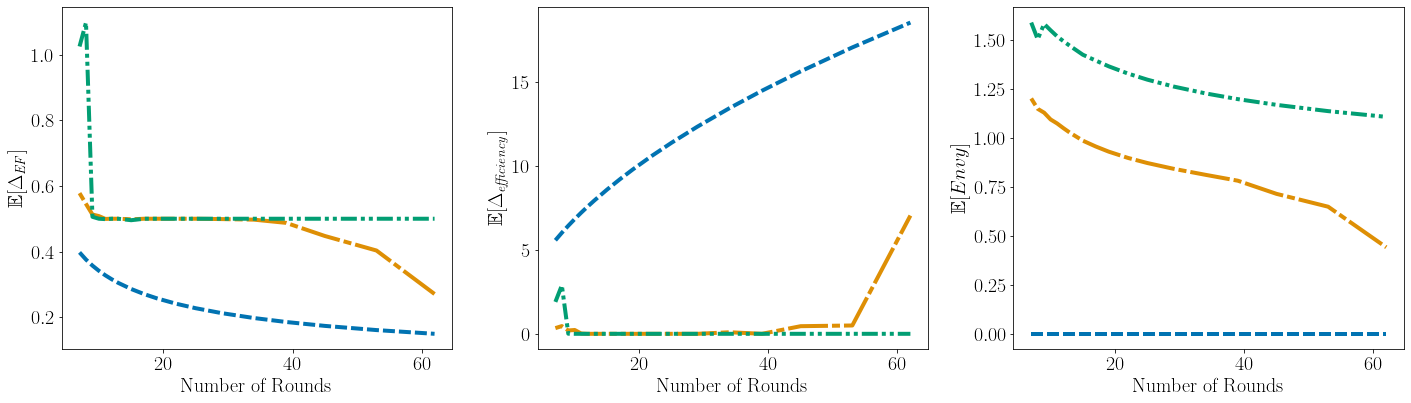

In [9]:

df.columns
df = df.assign(Algorithm = lambda df: df.Algorithm.replace({'fixed_threshold': 'Fixed Threshold', 'hope_guardrail_13': 'Guarded Hope $L_T = T^{-1/3}$', 'hope_guardrail_12': 'Guarded Hope $L_T = T^{-1/2}$'}))


plt.style.use('PaperDoubleFig.mplstyle.txt')
plt.rc('text.latex', preamble=r'\usepackage{amsfonts}')

# Make some style choices for plotting 
# colorWheel =['#2bd1e5',
#             '#281bf5',
#              '#db1bf5',
#              '#F5CD1B',
#             '#FF5733','#9cf51b',]
dashesStyles = [[3,1],
            [2,1,10,1],
            [4, 1, 1, 1, 1, 1],[1000,1],[8,2]]


#filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
#plt.figure(figsize=(20,10))
#plt.title('Simple Distribution L1')
#sns.lineplot(x='NumGroups', y='value', hue='variable', data=df[df.Norm == 'L1'])

filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
dash_styles = ["",
               (4, 1.5),
               (1, 1),
               (3, 1, 1.5, 1),
               (5, 1, 1, 1),
               (5, 1, 2, 1, 2, 1),
               (2, 2, 3, 1.5),
               (1, 2.5, 3, 1.2)]

# fig = plt.figure(figsize=(20,6))
plt.rc('text', usetex=True)



fg, axs = plt.subplots(1,3, sharex='all', figsize=(20,6))
sns.lineplot(x='NumGroups', y='Value', hue='Algorithm', style = 'Algorithm', dashes = dashesStyles[0:len(algo_list)],
                     data=df[df.Norm == 'Counterfactual_Envy'], ax = axs[0], linewidth=4, palette = sns.color_palette("colorblind", len(algo_list)),
            ci = None)
sns.lineplot(x='NumGroups', y='Value', hue='Algorithm', style = 'Algorithm', dashes = dashesStyles[0:len(algo_list)], 
             data=df[df.Norm == 'Waste'], ax = axs[1], linewidth=4, palette = sns.color_palette("colorblind", len(algo_list)),
            ci = None)

sns.lineplot(x='NumGroups', y='Value', hue='Algorithm', style = 'Algorithm', dashes = dashesStyles[0:len(algo_list)], 
             data=df[df.Norm == 'Hindsight_Envy'], ax = axs[2], linewidth=4, palette = sns.color_palette("colorblind", len(algo_list)),
            ci = None)

# sns.lineplot(x='NumGroups', y='Value', hue='Algorithm', style = 'Algorithm', dashes = dashesStyles[0:len(algo_list)],
#              data=df[df.Norm == 'Perished_Un_Allocated'], ax = axs[3], linewidth=4, palette = sns.color_palette("colorblind", len(algo_list)),
#             ci = None)


# axs[0].get_legend().remove()
axs[0].get_legend().remove()
axs[0].set_ylabel('$\mathbb{E}[\Delta_{\it EF}]$')
axs[0].set_xlabel('Number of Rounds')

axs[1].set_ylabel('$\mathbb{E}[\Delta_{\it efficiency}]$')
axs[1].set_xlabel('Number of Rounds')
axs[1].get_legend().remove()

axs[2].get_legend().remove()
axs[2].set_ylabel(r'$\mathbb{E}[Envy]$')
axs[2].set_xlabel('Number of Rounds')

# axs[3].get_legend().remove()
# axs[3].set_ylabel(r'Perished Un Allocated')
# axs[3].set_xlabel('Number of Rounds')


# axs[2].legend(ncol = 1, loc= 'upper right')




plt.show()
fg.savefig('./figures/synthetic_sqrt_perish.pdf', bbox_inches = 'tight',pad_inches = 0.01, dpi=900)